In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from hmmlearn import hmm


Необходимо предложить обоснованный прогноз отказа моторов и описать варианты использования предложенного решения на практике.

Описание данных (архив для загрузки в аттач ):
    id -- идентификатор мотора
    cycle -- цикл работы
    p00-p20 -- показания датчиков считываемые в процессе работы
    s0, s1 -- настройки изменяемые в конце каждого цикла

Считаем, что максимальный цикл мотора в данных - это последний цикл перед поломкой.
Базовый вариант – прогноз поломки на следующем цикле.

In [5]:
df = pd.read_csv('data/data.csv')
df

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,...,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,...,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,...,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,...,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002


In [53]:
df['id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)

In [13]:
df[df['id']==2]

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
192,2,1,518.67,1.3,46.93,522.33,2388.06,8137.72,8.3905,0.03,...,23.4585,1583.84,1391.28,14.62,21.60,554.53,2388.01,9054.72,-0.0018,0.0006
193,2,2,518.67,1.3,47.24,522.70,2387.98,8131.09,8.4167,0.03,...,23.4085,1587.05,1393.13,14.62,21.61,554.77,2387.98,9051.31,0.0043,-0.0003
194,2,3,518.67,1.3,47.22,522.58,2387.99,8140.58,8.3802,0.03,...,23.4250,1588.32,1398.96,14.62,21.60,555.14,2388.04,9054.24,0.0018,0.0003
195,2,4,518.67,1.3,47.10,522.49,2387.93,8140.44,8.4018,0.03,...,23.5027,1584.15,1396.08,14.62,21.61,554.25,2387.98,9058.01,0.0035,-0.0004
196,2,5,518.67,1.3,47.25,522.27,2387.94,8136.67,8.3867,0.03,...,23.4234,1579.03,1402.52,14.62,21.60,555.12,2388.03,9058.15,0.0005,0.0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2,283,518.67,1.3,48.21,520.07,2388.20,8174.85,8.5199,0.03,...,23.0358,1602.03,1429.67,14.62,21.61,551.46,2388.16,9084.13,0.0046,0.0002
475,2,284,518.67,1.3,48.18,519.95,2388.21,8166.83,8.5291,0.03,...,23.1196,1601.35,1430.04,14.62,21.61,551.96,2388.22,9089.87,-0.0006,0.0001
476,2,285,518.67,1.3,48.27,519.91,2388.22,8164.83,8.5242,0.03,...,23.1155,1596.84,1431.17,14.62,21.61,550.85,2388.20,9098.67,-0.0007,0.0004
477,2,286,518.67,1.3,48.14,519.51,2388.22,8169.97,8.4932,0.03,...,23.0169,1603.63,1429.57,14.62,21.61,551.61,2388.18,9102.01,-0.0010,-0.0003


In [18]:
# Удаление указанных колонок
columns_to_drop = ['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17', 'p20']
df.drop(columns=columns_to_drop, inplace=True)

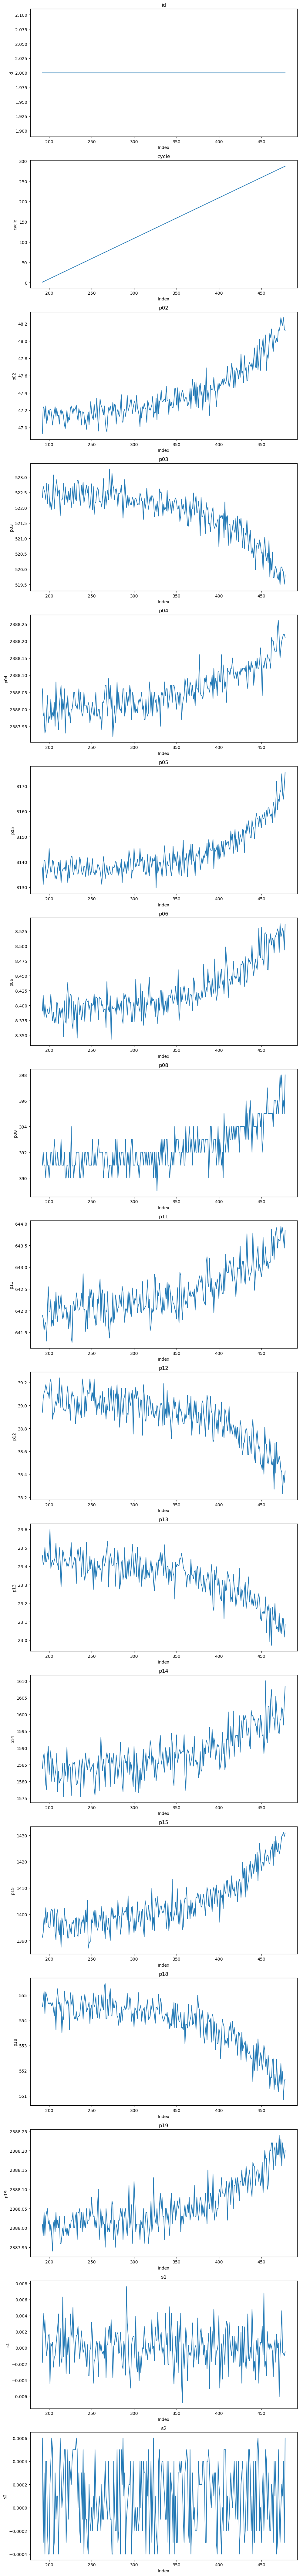

In [19]:
# Функция для построения графиков
def plot_columns(dataframe):
    num_columns = len(dataframe.columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns))

    for i, column in enumerate(dataframe.columns):
        ax = axes[i] if num_columns > 1 else axes
        dataframe[column].plot(ax=ax, title=column)
        ax.set_xlabel("Index")
        ax.set_ylabel(column)

    plt.tight_layout()
    plt.show()

# Построение графиков
plot_columns(df[df['id']==2])

In [16]:
# # Функция для построения графиков
# def plot_combined_columns(dataframe):
#     unique_ids = dataframe['id'].unique()
#     num_columns = len(dataframe.columns) - 1  # Исключаем колонку 'id'
#     fig, axes = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns), sharex=True)
# 
#     for i, column in enumerate(dataframe.columns):
#         if column != 'id':
#             ax = axes[i] if num_columns > 1 else axes
#             for unique_id in unique_ids:
#                 subset = dataframe[dataframe['id'] == unique_id]
#                 subset[column].plot(ax=ax, label=f'id={unique_id}')
#             ax.set_title(column)
#             ax.set_xlabel("Index")
#             ax.set_ylabel(column)
#             ax.legend()
# 
#     plt.tight_layout()
#     plt.show()
# 
# # Построение графиков
# plot_combined_columns(df)

In [23]:
one_motor_columns = df[df['id']==2]

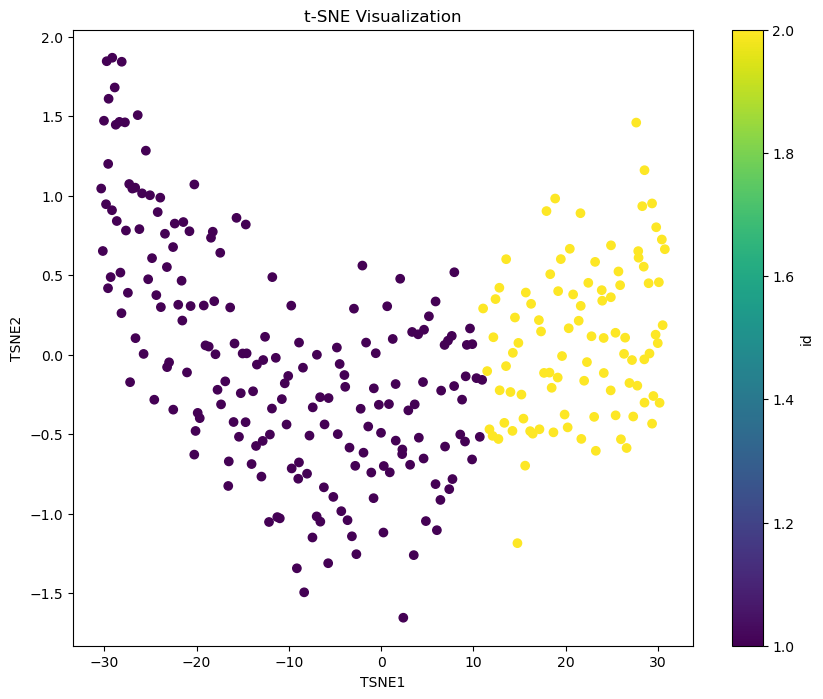

In [24]:
# Выбор данных для t-SNE (исключая колонку 'id')
data_for_tsne = one_motor_columns.drop(columns=['id'])

# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_for_tsne)

# Создание DataFrame для результатов t-SNE
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['id'] = df['id']

# Визуализация результатов t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['id'], cmap='viridis')
plt.colorbar(scatter, label='id')
plt.title('t-SNE Visualization')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

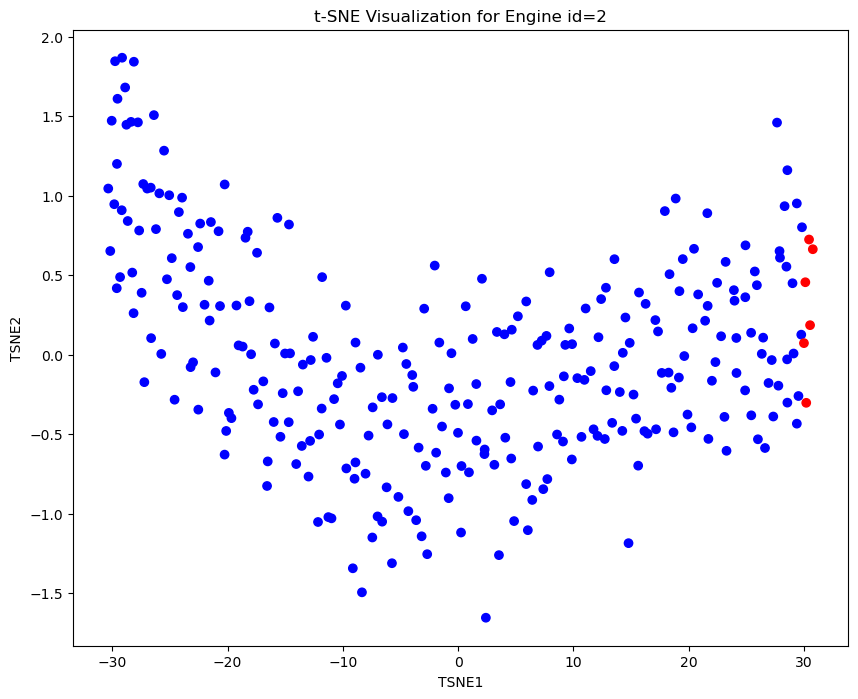

In [29]:


# Фильтрация данных для двигателя с id=2
one_motor_columns = df[df['id'] == 2].copy()

# Создание метки для последних 50 циклов
one_motor_columns['is_last_50_cycles'] = one_motor_columns['cycle'] >= (one_motor_columns['cycle'].max() - 5)

# Выбор данных для t-SNE (исключая колонку 'id' и 'is_last_50_cycles')
data_for_tsne = one_motor_columns.drop(columns=['id', 'is_last_50_cycles'])

# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_for_tsne)

# Создание DataFrame для результатов t-SNE
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['is_last_50_cycles'] = one_motor_columns['is_last_50_cycles'].values

# Визуализация результатов t-SNE
plt.figure(figsize=(10, 8))
colors = tsne_df['is_last_50_cycles'].apply(lambda x: 'red' if x else 'blue')
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=colors)
plt.title('t-SNE Visualization for Engine id=2')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

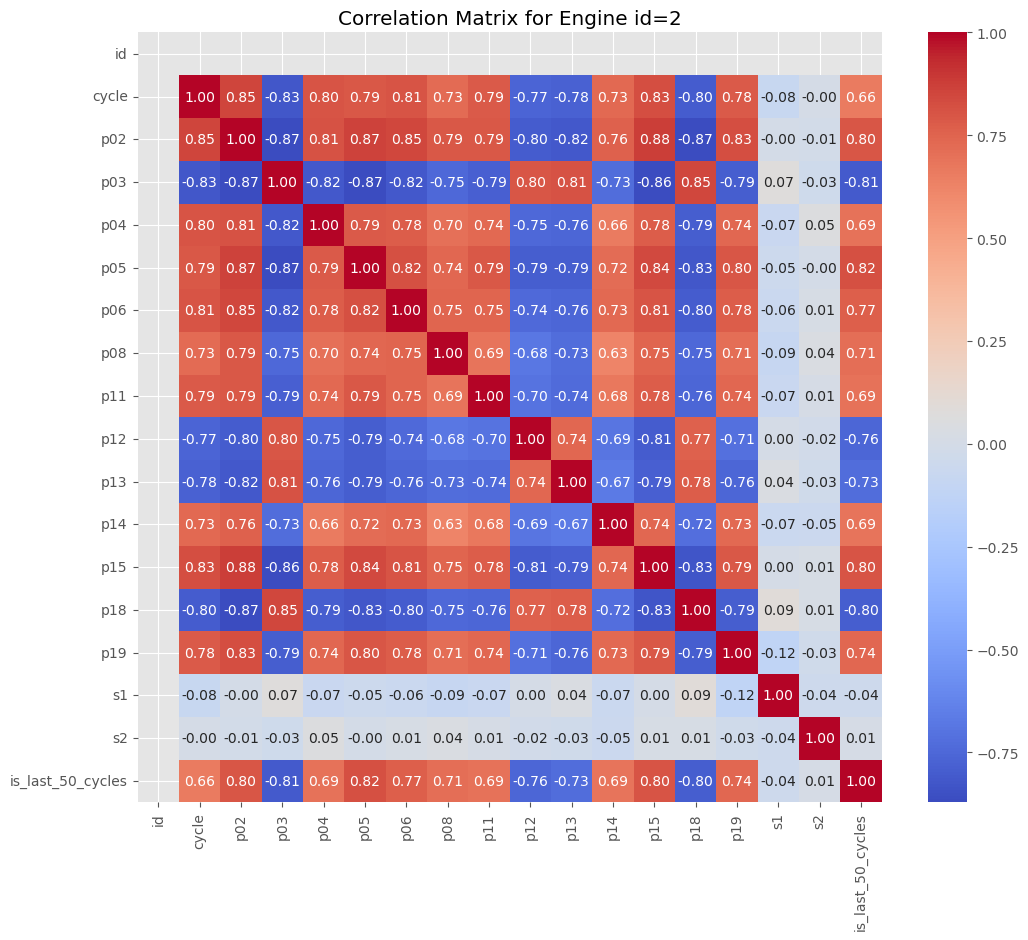

In [36]:

# Выбор данных для одного двигателя с id=2
one_motor_df = df[df['id'] == 2].copy()

# Построение матрицы корреляции
correlation_matrix = one_motor_df.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Engine id=2')
plt.show()

C:\ProgramData\anaconda3\envs\kaggle\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


     antecedents                     consequents  antecedent support  \
0          (p02)                           (p04)             0.49175   
1          (p04)                           (p02)             0.48575   
2          (p02)                           (p06)             0.49175   
3          (p06)                           (p02)             0.49950   
4          (p02)                           (p08)             0.49175   
...          ...                             ...                 ...   
8845       (p08)  (p02, p06, p19, p15, p11, p14)             0.31450   
8846       (p19)  (p02, p06, p08, p15, p11, p14)             0.47950   
8847       (p15)  (p02, p06, p19, p08, p11, p14)             0.50000   
8848       (p11)  (p02, p06, p19, p08, p15, p14)             0.49250   
8849       (p14)  (p02, p06, p19, p08, p15, p11)             0.49925   

      consequent support  support  confidence      lift  leverage  conviction  \
0                0.48575  0.34525    0.702084  1.44536

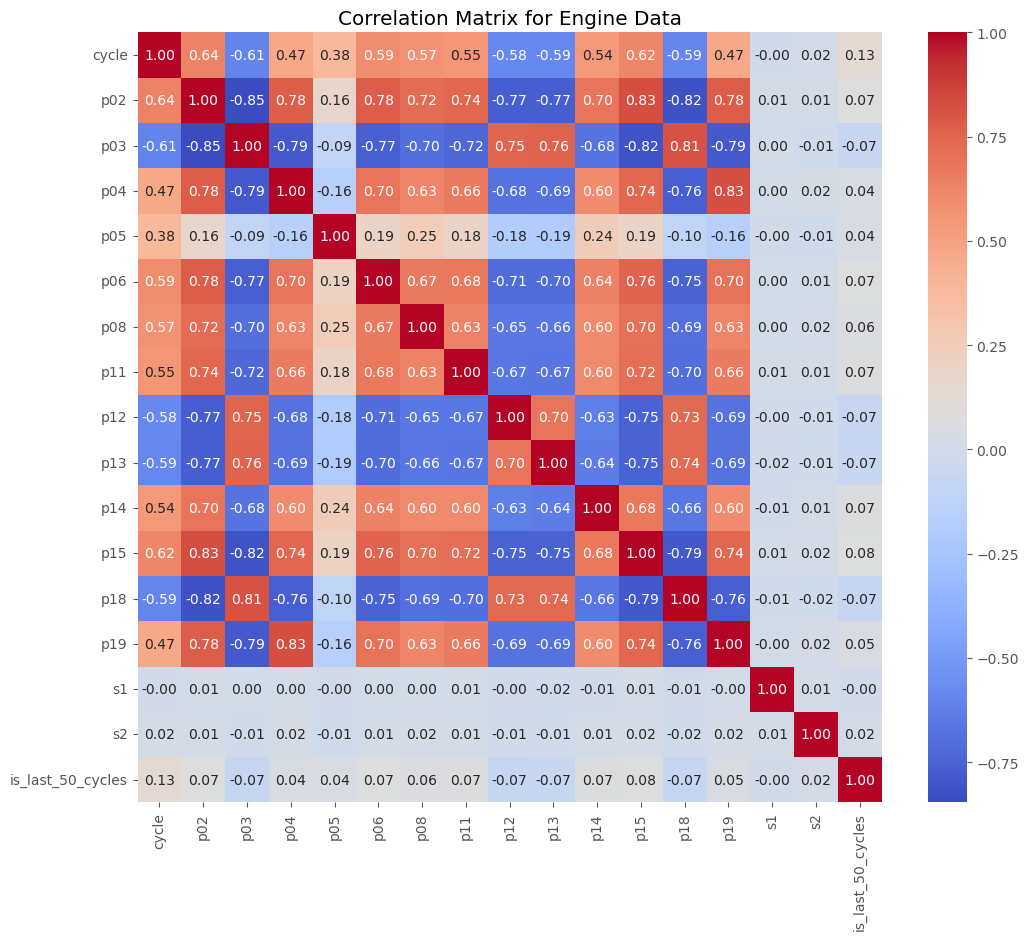

In [48]:

# Преобразование всех данных в числовой формат
df = df.apply(pd.to_numeric, errors='coerce')

# Заполнение пропущенных значений
df.fillna(df.median(), inplace=True)

# Подготовка данных
# Выделение окон размера L перед последним циклом каждого мотора
L = 50
windows = []
for motor_id in df['id'].unique():
    motor_data = df[df['id'] == motor_id]
    max_cycle = motor_data['cycle'].max()
    if max_cycle > L:
        window = motor_data[motor_data['cycle'] > (max_cycle - L)]
        windows.append(window)

window_df = pd.concat(windows)

# Заполнение пропущенных значений в окне
window_df.fillna(window_df.median(), inplace=True)

# Бинаризация данных для Apriori
def binarize_data(df):
    binary_df = df.copy()
    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64]:
            median = df[column].median()
            binary_df[column] = (df[column] > median).astype(int)
    return binary_df

binary_window_df = binarize_data(window_df.drop(columns=['id', 'cycle']))

# Применение алгоритма Apriori
frequent_itemsets = apriori(binary_window_df, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Вывод найденных правил
print(rules)

# Подготовка данных для HMM
# Формирование данных для HMM
X = []
lengths = []
for motor_id in df['id'].unique():
    motor_data = df[df['id'] == motor_id].drop(columns=['id'])
    X.append(motor_data.values)
    lengths.append(len(motor_data))

X = np.concatenate(X)

# Создание и обучение HMM
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
model.fit(X, lengths)

# Прогнозирование отказов
test_motor_data = df[df['id'] == 3].drop(columns=['id'])  # Пример тестовых данных для одного мотора
logprob, state_sequence = model.decode(test_motor_data.values, algorithm="viterbi")

# Вывод результатов прогнозирования
print("Логарифм вероятности: ", logprob)
print("Последовательность состояний: ", state_sequence)

# Построение матрицы корреляции
correlation_matrix = df.drop(columns=['id']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Engine Data')
plt.show()

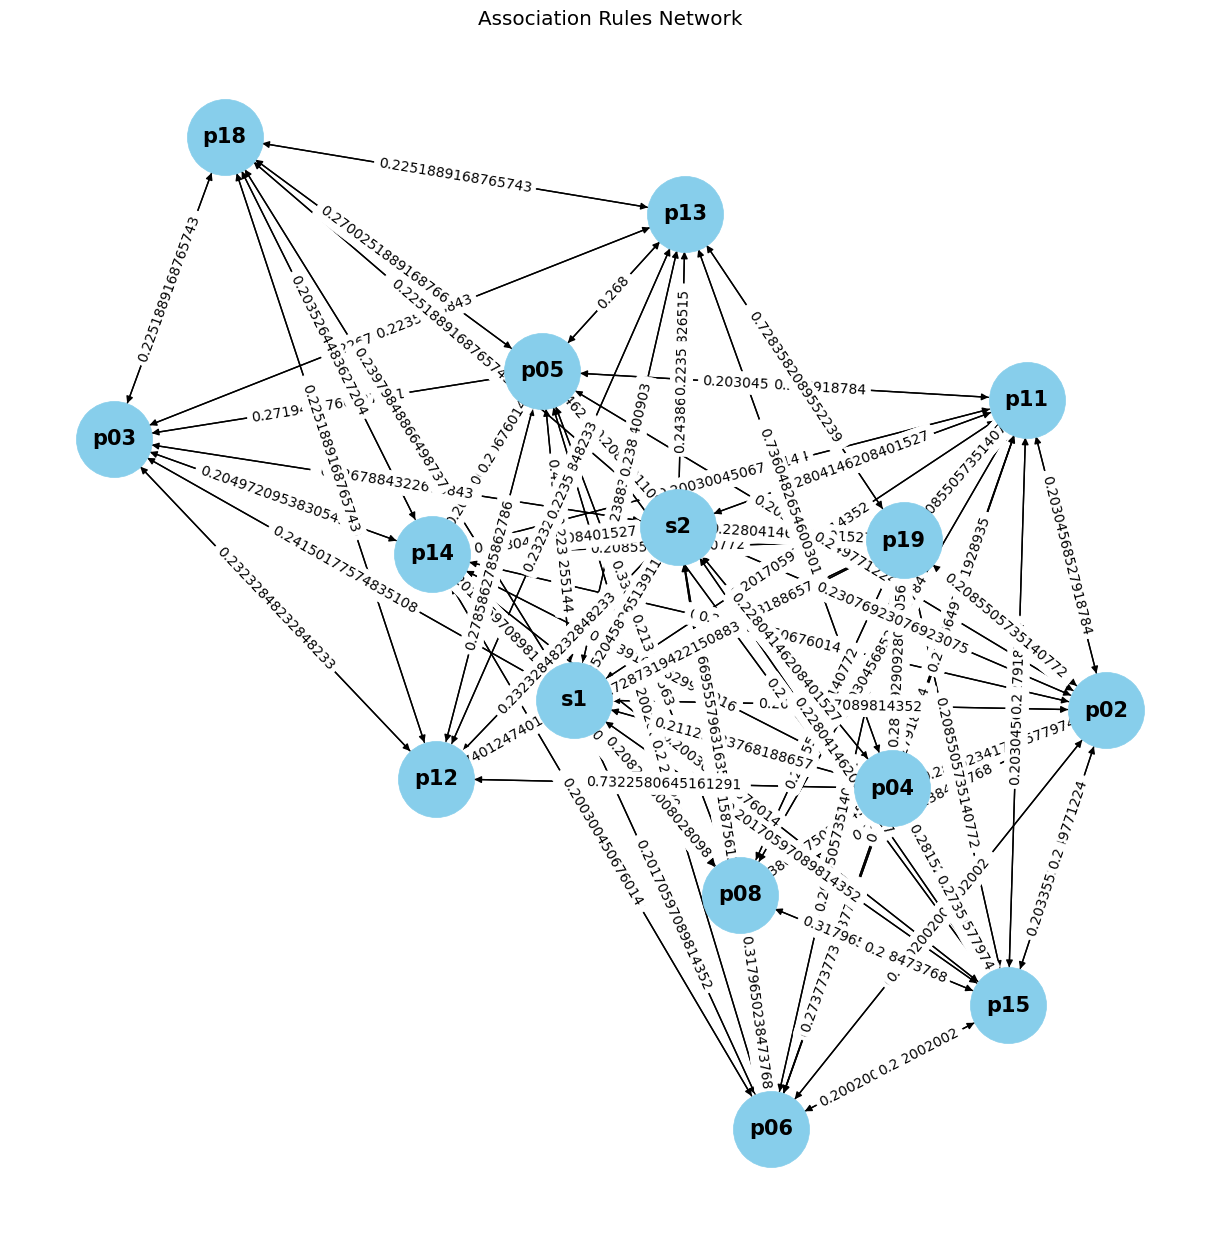

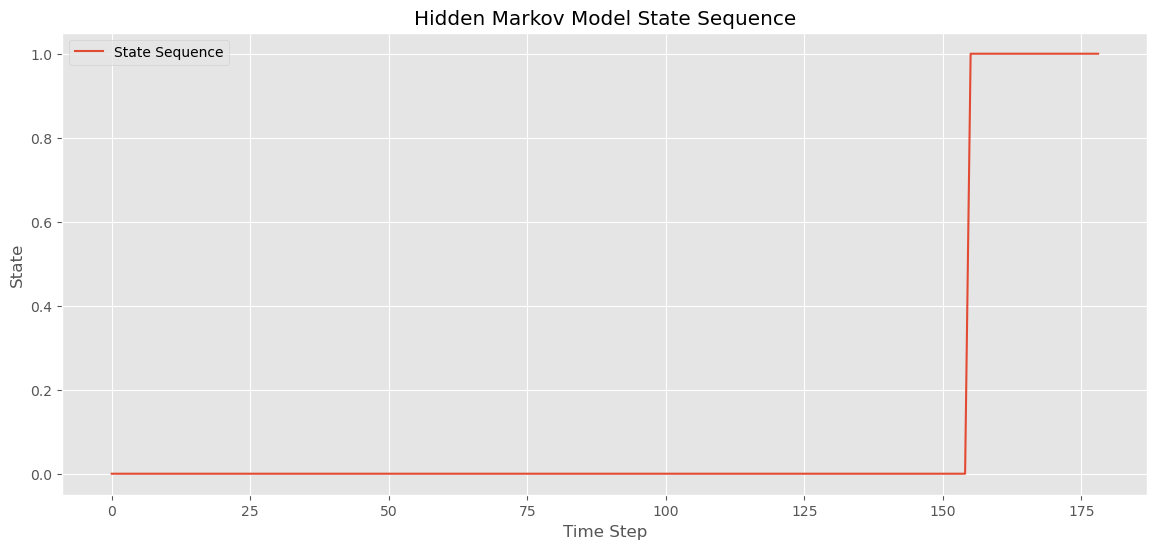

In [49]:
import matplotlib.pyplot as plt
import networkx as nx

# Визуализация ассоциативных правил
def plot_association_rules(rules):
    G = nx.DiGraph()

    for i, rule in rules.iterrows():
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['confidence'])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, font_weight="bold")
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title('Association Rules Network')
    plt.show()

# Визуализация последовательности состояний
def plot_state_sequence(state_sequence):
    plt.figure(figsize=(14, 6))
    plt.plot(state_sequence, label='State Sequence')
    plt.xlabel('Time Step')
    plt.ylabel('State')
    plt.title('Hidden Markov Model State Sequence')
    plt.legend()
    plt.show()

# Вызов функций визуализации
plot_association_rules(rules)
plot_state_sequence(state_sequence)


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Загрузка данных
file_path = 'data/data.csv'
df = pd.read_csv(file_path)

# Удаление указанных колонок
columns_to_drop = ['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17', 'p20']
df.drop(columns=columns_to_drop, inplace=True)

# Преобразование всех данных в числовой формат
df = df.apply(pd.to_numeric, errors='coerce')

# Заполнение пропущенных значений
df.fillna(df.median(), inplace=True)

# Создание меток для выхода из строя
# Последний цикл каждого двигателя считается как выход из строя
df['failure'] = df.groupby('id')['cycle'].transform(lambda x: x == x.max()).astype(int)

# Подготовка данных для обучения
X = df.drop(columns=['id', 'cycle', 'failure'])
y = df['failure']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели случайного леса
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Прогнозирование выхода из строя для новых данных
new_data = df[df['id'] == 3].drop(columns=['id', 'cycle', 'failure'])
failure_prediction = model.predict(new_data)
print("Failure Prediction for new data:\n", failure_prediction)


Accuracy: 0.9959727385377943
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3214
           1       0.67      0.14      0.24        14

    accuracy                           1.00      3228
   macro avg       0.83      0.57      0.62      3228
weighted avg       0.99      1.00      0.99      3228

Confusion Matrix:
 [[3213    1]
 [  12    2]]
Failure Prediction for new data:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
